In [11]:
import sys
from functools import partial
from zipfile import ZipFile
import pandas as pd
import numpy as np # linear algebra
sys.path.append('../src')
sys.path
%matplotlib inline

# Your contact details

In [2]:
# If you're having problem importing this file, copy and paste the contents of "uatt.py" in this cell instead
# of the import statement
from uatt import submit
my_submit = partial(submit, "Matan Cohen", "IAI", "matanco88@gmail.com", "050")

# Read data

In [3]:
data = []
with ZipFile("../data/data.zip") as z:
    for fname in z.namelist():
        if not fname.endswith('.txt') or not fname.startswith('data'):
            continue
        content = z.read(fname).decode('utf8')
        label, idx = fname[5:-4].split('-', 1)
        data.append((idx,label,content,))
df_train = pd.DataFrame(data, columns=("id", "label", "content"))
df_train.sample(10)

,id,label,content
2596,19800,rsu,EXHIBIT 10.1\n\n\n\nUNDER THE WATTS WATER TECH...
784,03070,credit,"Exhibit 4.25\n\nJanuary 15, 2004\n\nKentucky U..."
1092,06150,employment,##### \n\nExhibit 10.18(d)\n\n\n\nThis EMPLOYM...
3351,27350,rsu,"CUISINE SOLUTIONS, INC.\n\n\n\n(2007 EQUITY IN..."
3315,26990,rsu,Exhibit 10.20 \n\n50% Acceleration if Terminat...
1150,06730,employment,\n\n\n \n\n\nExhibit 10.5\n\n\n\nThis AGREE...
963,04860,employment,Ex. 10.1\n\n \n\n\n\n\nWITH SILVERLEAF RESORT...
3607,29910,rsu,Exhibit 10.2 \n\nF.N.B. CORPORATION\n\n\n(Purs...
4289,36730,rsu,\n\n\n \n\n\nExhibit 10.4 \n\n\n\nThis Rest...
1153,06760,employment,\n\n\n \n\n\n\n\n \n\n\nThis Employment Ag...


In [4]:
data = []
with ZipFile("../data/test_data.zip") as z:
    for fname in z.namelist():
        content = z.read(fname).decode('utf8')
        if not fname.endswith('.txt') or not fname.startswith('test'):
            continue
        idx = fname[5:-4]
        data.append((idx,content,))
df_test = pd.DataFrame(data, columns=("id", "content"))
df_test.sample(10)

,id,content
326,kdcgm,Exhibit 10.31 \n\n\n\nPURSUANT TO THE SEACOR H...
52,bvfdc,Exhibit 3.1\n\n\n\nOF THE\n\nARTICLES OF INCOR...
178,fvpzx,Exhibit 10.2\n\n\n\nThis Registration Rights A...
710,xdpqc,EXHIBIT 10.1\n\nJAMES E. GOULD \n\n\nTHIS AGR...
104,dnbxa,EXHIBIT 10.31\n\n\n\n \n\n\nTHIS EMPLOYMENT A...
379,mgots,LONG TERM INCENTIVE\n\n\n\nThis Long Term Ince...
224,hduys,EXHIBIT 10.1\n\n \n\n\n\n\n \n\n\nThis Emplo...
309,joenm,"Exhibit 10.1\n\n \n\n\n\n\nMarch 1, 2015 Awar..."
193,gjqfd,Exhibit 10.02.06 \n\n\n\nThis Employment Agree...
40,bncsq,"Exhibit 3.2\n\n\n\nof\n\nRALCORP HOLDINGS, INC..."


# Plot distribution of labels

<AxesSubplot:>

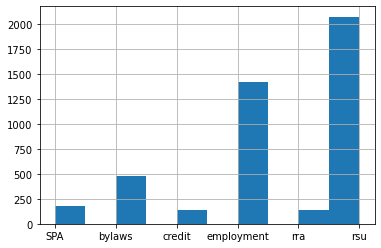

In [5]:
df_train["label"].hist()

# Submit
## Sample submission 1: "All RSU"

In [6]:
# for all documents
df_test["label"] = "rsu"
submission = dict(df_test[["id","label"]].values)
#submission name must be unique
submission_name = "uri_most_likely"
#my_submit(submission_name, submission)
df_test.sample(10)

,id,content,label
661,vkzoe,##### \n\nExhibit 10.5 \n\nExhibit C\n\nHARMAN...,rsu
59,capdi,Exhibit 10.1 \n\n![LOGO](g51268dsp006.jpg)\n\n...,rsu
254,hxiuv,Exhibit 10.3(b)\n\nThe information that is mar...,rsu
19,aroji,Exhibit 10.2\n\n \n\n\nBAKER HUGHES INCORPORA...,rsu
802,zmaxf,Exhibit 10.31 \n\nCOOPER-STANDARD HOLDINGS INC...,rsu
211,guxqe,Exhibit 3.1\n\nAMENDED AND RESTATED\n\n\n\nOF\...,rsu
114,ebisd,Exhibit 10.4\n\n\n\nAGREEMENT effective Januar...,rsu
37,biceo,Exhibit 10.2 \n\n\n\nTHIS REGISTRATION RIGHTS ...,rsu
169,fmzes,"\nExhibit 10.7\n\n \n\n\nULTICOM, INC.\n\n\...",rsu
387,mltea,Exhibit 10-3-3 \n\n\n\nPERFORMANCE SHARES \n\n...,rsu


## Sample submission 2: Submission by string search


In [24]:
df_test["label"] = "rsu"
df_test.loc[df_test["content"].str.contains("EMPLOYMENT"),"label"] = 'employment'
df_test.loc[df_test["content"].str.contains("CREDIT"),"label"] = 'credit'
df_test.loc[df_test["content"].str.contains("BYLAWS"),"label"] = 'bylaws'
df_test.loc[df_test["content"].str.contains("REGISTRAR"),"label"] = 'rra'
df_test.loc[df_test["content"].str.contains("SELLER"),"label"] = 'SPA'
submission = dict(df_test[["id","label"]].values)
submission_name = "matan_string_search"
my_submit(submission_name, submission)
#df_test.sample(10)

0.65085158150852

In [20]:
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sqlite3 import Error
from sklearn.ensemble import RandomForestClassifier
import sqlite3
import pickle
import nltk
#nltk.download('stopwords')

stemmer = PorterStemmer()
words = stopwords.words("english")
df_train['cleaned'] = df_train['content'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())
df_test['cleaned'] = df_test['content'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())
#df_train.head()
vectorizer = TfidfVectorizer(min_df= 3, stop_words="english", sublinear_tf=True, norm='l2', ngram_range=(1, 2))
final_features = vectorizer.fit_transform(df_train['content']).toarray()
final_features.shape

(4427, 254636)

In [21]:
from sklearn.linear_model import LogisticRegression
#X = df_train['content']
#Y = df_train['label']
#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)
X_train = df_train['cleaned']
y_train = df_train['label']
X_test = df_test['cleaned']
y_test = df_test['label']

pipeline = Pipeline([('vect', vectorizer),
                     ('chi',  SelectKBest(chi2, k=1200)),
                     ('clf', LogisticRegression(random_state=0))])

model = pipeline.fit(X_train, y_train)
with open('LogisticRegression.pickle', 'wb') as f:
    pickle.dump(model, f)
df_test['label'] = model.predict(X_test)
df_test.sample(10)
#ytest = np.array(y_test)

# confusion matrix and classification report(precision, recall, F1-score)
#print(classification_report(ytest, model.predict(X_test)))
#print(confusion_matrix(ytest, model.predict(X_test)))

,id,content,label,cleaned
154,fcuap,Exhibit 10.3 \n\nTHE CHUBB CORPORATION \n\nLON...,rsu,exhibit the chubb corpor long term incent plan...
208,gslpc,Exhibit 10.19\n\nFRANCESCA’S HOLDINGS CORPORAT...,rsu,exhibit francesca s hold corpor equiti incent ...
805,znfsh,\n\n\nExhibit 10.8\n\n\n\n \n\n\nBy and bet...,rsu,exhibit by the sharehold beij ruijieao bio tec...
518,qnzgb,\nQuickLinks \-- Click here to rapidly navig...,employment,quicklink click rapidli navig document exhibit...
808,zqoru,SECOND AMENDMENT TO\n\n\n\nThis SECOND AMENDME...,employment,second amend to thi second amend to employ agr...
516,qnjdp,Exhibit 10.3 \n\n\n![](lin8kx22x1.jpg)\n\n___...,rsu,exhibit lin kx x jpg to on award option purcha...
552,rvkeg,Exhibit 2.5\n\n\n\nSTOCK PURCHASE AGREEMENT\n\...,SPA,exhibit stock purchas agreement thi stock purc...
294,jenok,Exhibit 10.1 \n \n\n\nTHIS STOCK PURCHASE AG...,rsu,exhibit thi stock purchas agreement date march...
430,npyak,Exhibit 10a \n\nVERIZON COMMUNICATIONS INC. LO...,rsu,exhibit verizon commun inc long term incent pl...
707,xbzhr,Exhibit 10.2\n\n \n\n\nMOSCOW CABLECOM CORP.\...,rsu,exhibit moscow cablecom corp thi agreement agr...


In [22]:
submission = dict(df_test[["id","label"]].values)
submission_name = "Matan_Cohen_NLP_clean_text"
my_submit(submission_name, submission)

0.94038929440389

# See how you rank
Leaderboard is available at:
https://goren.ml/uattcontract

Accuracy of **90%** and above is required to pass the test

## Leaderboard not refreshing ?
try adding a random suffix to it, like this one:

In [25]:
import random, string
from IPython.display import HTML
rand_str = lambda: "".join(random.sample(string.ascii_letters,7))
HTML('<a href="https://goren.ml/uattcontract/?{k}={v}" target="_blank">Go to Leaderboard</a>'.format(k=rand_str(),v=rand_str()))